In [38]:
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, regularizers
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau , ModelCheckpoint
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns

In [3]:
image_size = (128, 128)
data_dir = "/kaggle/input/realwaste/realwaste-main/RealWaste"

X = []
y = []

exclude_folders = ['README.md']
class_names = sorted([d for d in os.listdir(data_dir) if d not in exclude_folders])

for label, class_name in enumerate(class_names):
    class_path = os.path.join(data_dir, class_name)
    if not os.path.isdir(class_path):  # skip if not a folder
        continue
    for img_file in os.listdir(class_path):
        if img_file.endswith(".jpg"):
            img_path = os.path.join(class_path, img_file)
            img = Image.open(img_path).resize(image_size).convert('RGB')
            img_array = np.array(img) / 255.0  
            X.append(img_array)
            y.append(label)

X = np.array(X, dtype=np.float32)
y = np.array(y, dtype=np.int32)




In [4]:
print(y.shape)
print(X.shape)

(4752,)
(4752, 128, 128, 3)


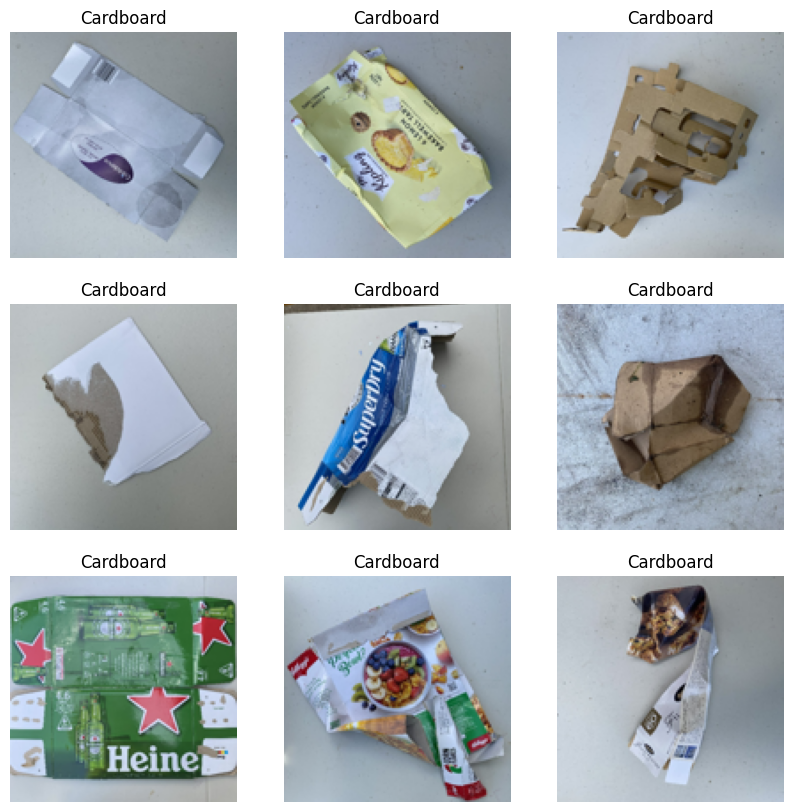

In [5]:


plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(X[i+100])
    plt.title(class_names[y[i+100]])
    plt.axis("off")

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_rest, y_train, y_rest = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)


In [7]:
X_test, X_val, y_test, y_val = train_test_split(
    X_rest, y_rest, test_size=0.5, random_state=42, stratify=y_rest
)

In [34]:

model = models.Sequential([
    layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(128, 128, 3)),
    layers.MaxPooling2D(),
    
    layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(256, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(512, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D(),

    layers.Flatten(),
    layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.2),
    layers.Dense(len(class_names), activation='softmax')
])




In [35]:
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

checkpoint = ModelCheckpoint(
    'best_CNN.h5',            
    monitor='val_loss',         
    mode='min',                 
    save_best_only=True,        
    verbose=1
)


history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=32,
    callbacks=[checkpoint] 
)

Epoch 1/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.1810 - loss: 2.9581
Epoch 1: val_loss improved from inf to 2.40059, saving model to best_CNN.h5
104/104 ━━━━━━━━━━━━━━━━━━━━ 13s 71ms/step - accuracy: 0.1813 - loss: 2.9564 - val_accuracy: 0.3015 - val_loss: 2.4006
Epoch 2/20
102/104 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.3366 - loss: 2.2156
Epoch 2: val_loss improved from 2.40059 to 1.93977, saving model to best_CNN.h5
104/104 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.3375 - loss: 2.2120 - val_accuracy: 0.4039 - val_loss: 1.9398
Epoch 3/20
102/104 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.4209 - loss: 1.8436
Epoch 3: val_loss improved from 1.93977 to 1.73260, saving model to best_CNN.h5
104/104 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.4215 - loss: 1.8421 - val_accuracy: 0.4474 - val_loss: 1.7326
Epoch 4/20
103/104 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.5019 - loss: 1.6280
Epoch 4: val_loss improved from 1.73260 to 1.58752, saving mo

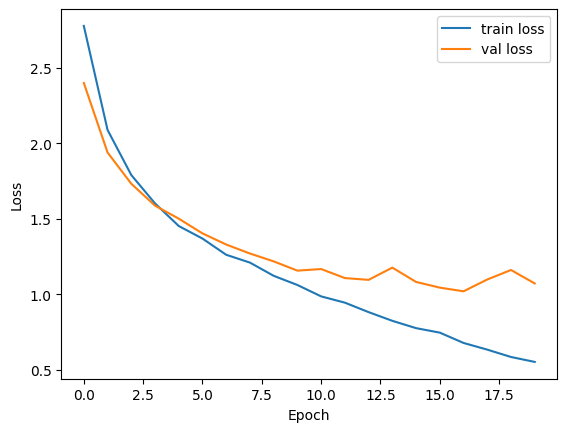

In [36]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


 Best Model - Test Accuracy: 0.7195
 Best Model - Test Loss: 1.0306
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step

 Classification Report:
                     precision    recall  f1-score   support

          Cardboard     0.9020    0.6667    0.7667        69
      Food Organics     0.8545    0.7705    0.8103        61
              Glass     0.8548    0.8413    0.8480        63
              Metal     0.6783    0.6555    0.6667       119
Miscellaneous Trash     0.5932    0.4730    0.5263        74
              Paper     0.7000    0.8400    0.7636        75
            Plastic     0.6710    0.7536    0.7099       138
      Textile Trash     0.4918    0.6250    0.5505        48
         Vegetation     0.8769    0.8636    0.8702        66

           accuracy                         0.7195       713
          macro avg     0.7358    0.7210    0.7236       713
       weighted avg     0.7285    0.7195    0.7197       713



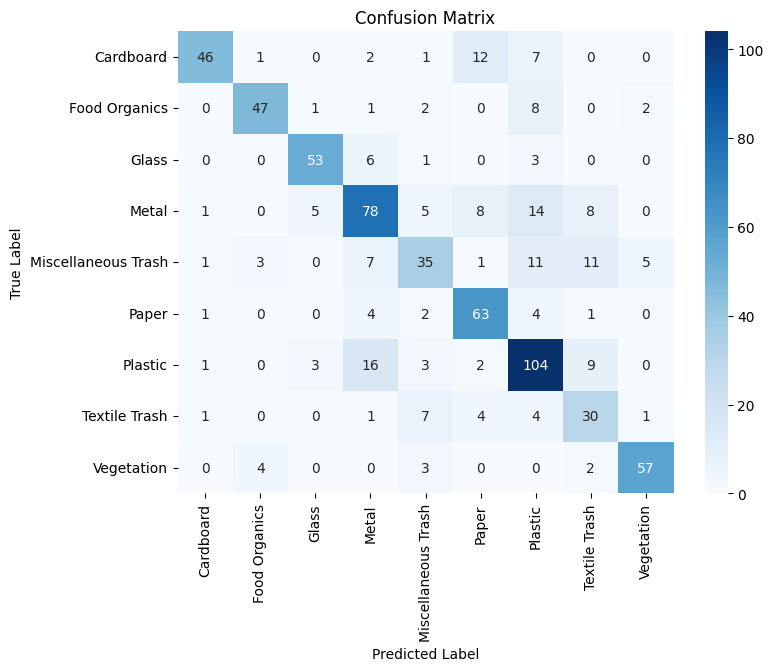

Overall Accuracy (check): 0.7195


In [39]:
best_model = load_model('best_CNN.h5')

test_loss, test_acc = best_model.evaluate(X_test, y_test, verbose=0)
print(f" Best Model - Test Accuracy: {test_acc:.4f}")
print(f" Best Model - Test Loss: {test_loss:.4f}")


y_pred_probs = best_model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)


print("\n Classification Report:")
print(classification_report(y_test, y_pred, target_names=class_names, digits=4))


cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


acc = accuracy_score(y_test, y_pred)
print(f"Overall Accuracy (check): {acc:.4f}")
